<a href="https://colab.research.google.com/github/juan-ivan-NV/Btc_trading/blob/master/Cryptocurrencies_forecastings_data_by_hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

## Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
# ► For prophet model (Time series)

import fbprophet
import matplotlib.pyplot as plt

In [4]:
# ► For PyCaret model (Regression models)

!pip install pycaret==2.0
#from pycaret.regression import *  # we will rin this line in next sections

In [4]:
# ► For arima model (Time series)

!pip install pmdarima
from pmdarima.arima import auto_arima
from scipy import stats
from itertools import product
import warnings
import statsmodels.api as sm

In [7]:
# ► Libraries for xgboost

import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [8]:
# ► libraries for LSTM and GRU RNN's

# ► To flat a list of lists
from pandas.core.common import flatten
# ► Scale Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler                
# ► Indicator
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
# ► Model Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense, GRU, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD

## Exploring data

In [5]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv', header=1)
kill_am = lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %I-%p')
data['Date'] = data['Date'].apply(kill_am)
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT
0,1.601363e+09,2020-09-29 07:00:00,BTCUSDT,10742.46,10745.42,10726.16,10726.16,185.20,1987813.05
1,1.601359e+09,2020-09-29 06:00:00,BTCUSDT,10680.87,10747.88,10668.26,10742.46,1762.27,18868995.88
2,1.601356e+09,2020-09-29 05:00:00,BTCUSDT,10694.48,10700.00,10670.00,10680.87,1169.17,12494919.04
3,1.601352e+09,2020-09-29 04:00:00,BTCUSDT,10689.94,10713.25,10687.89,10694.48,993.53,10631885.02
4,1.601348e+09,2020-09-29 03:00:00,BTCUSDT,10689.37,10710.00,10682.23,10689.94,1101.55,11782521.16


In [6]:
data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT
27335,1.502957e+09,2017-08-17 08:00:00,BTCUSDT,4349.99,4377.85,4333.32,4360.69,0.9499,4139.70
27336,1.502953e+09,2017-08-17 07:00:00,BTCUSDT,4324.35,4349.99,4287.41,4349.99,4.4400,19241.06
27337,1.502950e+09,2017-08-17 06:00:00,BTCUSDT,4315.32,4345.45,4309.37,4324.35,7.2300,31282.31
27338,1.502946e+09,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.2300,100304.82
27339,1.502942e+09,2017-08-17 04:00:00,BTCUSDT,16199.91,16199.91,4261.32,4308.83,44.5100,190952.85


In [7]:
data.dtypes

Unix Timestamp           float64
Date              datetime64[ns]
Symbol                    object
Open                     float64
High                     float64
Low                      float64
Close                    float64
Volume BTC               float64
Volume USDT              float64
dtype: object

In [8]:
len(data)

27340

In [9]:
my_coin = data.copy()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Open'],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['High'],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Low'],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Close'],
                    mode='lines',
                    name='Close'))

#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="BTC by hours, price in USDT")


# Models

I will let 3 days to compare

In [11]:
my_coin = data[['High','Date']].copy()[::-1]

In [12]:
# ► Data for training till last 72 hours

my_coin_high_train = my_coin[['High','Date']][:-72]

In [13]:
# ► Data for testing 72 hours

my_coin_high_test = my_coin[['High','Date']][-72:]

## FbProphet

In [14]:
# ► Renaming columns for Prophet syntax

my_coin_high_p = my_coin_high_train.rename(columns = {'Date':'ds','High':'y'})

In [15]:
m = fbprophet.Prophet(changepoint_prior_scale=1.1)

In [16]:
m.fit(my_coin_high_p)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [17]:
# ► Generating future 20 dates

future = m.make_future_dataframe(freq='H',periods=72)

In [18]:
len(future)

27340

In [19]:
# ► Predicting those days

forecast_p = m.predict(future)

In [20]:
len(forecast_p)

27340

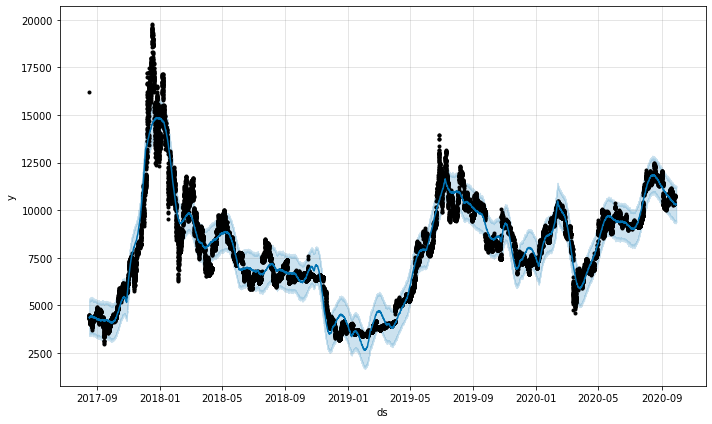

In [21]:
m.plot(forecast_p);

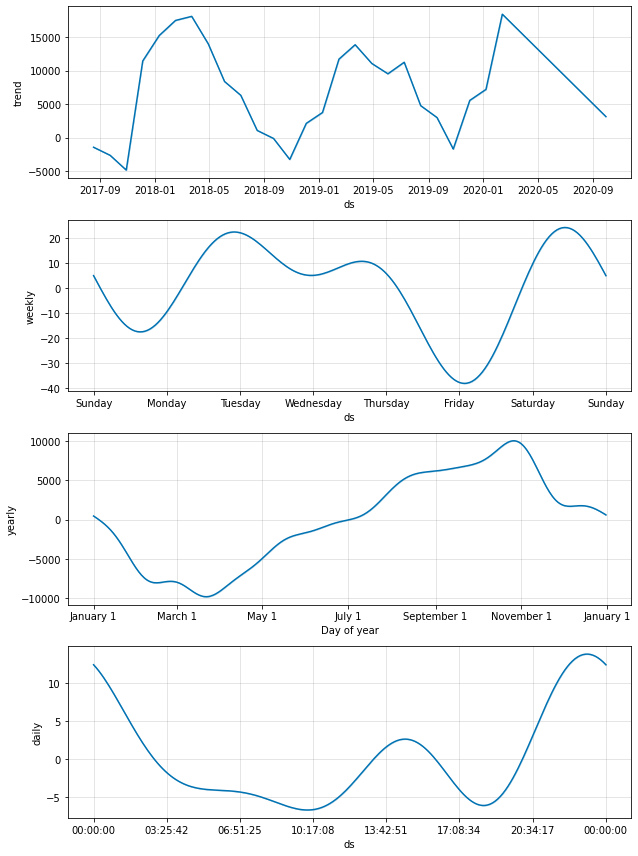

In [22]:
m.plot_components(forecast_p);

In [23]:
# ► predictions and real price

my_coin_inverse = my_coin.copy() 
my_coin_inverse.High = my_coin_inverse.High.values[::-1]                        # To change value orders from the original data
my_coin_forecast = pd.concat([forecast_p['ds'],my_coin_inverse['High'],forecast_p['yhat']], axis=1,keys=['date','high','prophet_high'])

In [24]:
# ► The model didn't see this high values

my_coin_forecast.tail()

,date,high,prophet_high
27335,2020-09-29 03:00:00,10710.00,10311.481945
27336,2020-09-29 04:00:00,10713.25,10308.000085
27337,2020-09-29 05:00:00,10700.00,10305.873213
27338,2020-09-29 06:00:00,10747.88,10304.399836
27339,2020-09-29 07:00:00,10745.42,10302.825811


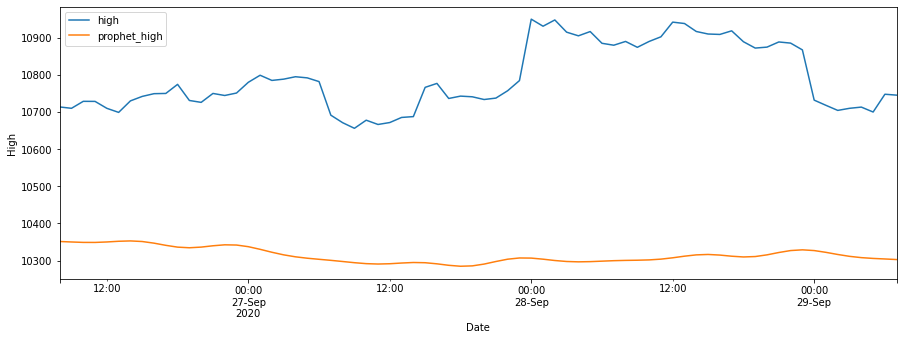

In [25]:
# ► Plot las 72 predictions and samples

ax = my_coin_forecast.set_index('date')[-72:].plot(figsize=(15, 5))
ax.set_ylabel('High')
ax.set_xlabel('Date')

plt.show()

## Arima

In [26]:
# ► Create a copy with values in reverse

my_coin_high_a = (my_coin[['Date','High']][:-72].copy()).set_index('Date')

In [27]:
my_coin_high_a.tail()

,High
Date,
2020-09-26 03:00:00,10746.66
2020-09-26 04:00:00,10737.11
2020-09-26 05:00:00,10820.94
2020-09-26 06:00:00,10766.00
2020-09-26 07:00:00,10739.35


In [ ]:
# Arima tunning hyperparameters
# Initial approximation of parameters

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(my_coin_high_a.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# ► Forecasting and renaming forecasting column

forecast_arima = pd.DataFrame(best_model.predict(start=0, end=len(my_coin_forecast)-1))
forecast_arima = forecast_arima.rename(columns = {0:'arima_high'})

In [ ]:
# ► Joining data frames

my_coin_forecast_cp = pd.concat([my_coin_forecast.set_index('date'),forecast_arima], axis = 1, sort = False)

In [ ]:
# ► Comparing 72 unseen data by both models

my_coin_forecast_cp.tail()


In [ ]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-72:].plot()
my_coin_forecast_cp.arima_high[-72:].plot(color='r', ls='--', label='ARIMA Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

## XGBoost